Training size: 100 | Test Accuracy: 62.43%
Training size: 500 | Test Accuracy: 79.79%
Training size: 1000 | Test Accuracy: 85.21%
Training size: 2000 | Test Accuracy: 86.79%
Training size: 4000 | Test Accuracy: 88.36%
Training size: 6000 | Test Accuracy: 88.88%
Training size: 8000 | Test Accuracy: 90.02%
Training size: 56000 | Test Accuracy: 91.03%


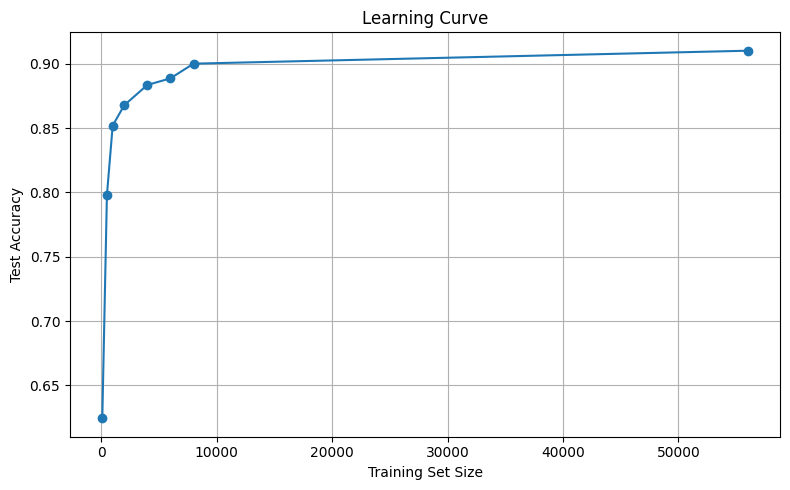

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from skimage.transform import resize
import cvxpy as cp

# Load MNIST
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target'].astype(int)

# Convert 2D data to 3D images
X_images = X.values.reshape(-1, 28, 28)

# Resize 28x28 to 9x9 and flatten
X_resized = np.array([resize(img, (9, 9), mode='reflect', anti_aliasing=True).flatten() for img in X_images])

# Fisher Score Feature Selection
def fisher_score(X, y):
    scores = []
    for i in range(X.shape[1]):
        feature = X[:, i]
        mean_overall = np.mean(feature)
        numerator, denominator = 0, 0
        for c in np.unique(y):
            fc = feature[y == c]
            numerator += len(fc) * (np.mean(fc) - mean_overall) ** 2
            denominator += len(fc) * np.var(fc)
        scores.append(numerator / (denominator + 1e-6))
    return np.array(scores)

# Shuffle and split data
X_resized, y = shuffle(X_resized, y, random_state=42)
X_train_full, X_test, y_train_full, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

# Fisher feature selection on full training set
fisher_scores = fisher_score(X_train_full, y_train_full)
top_features = np.argsort(fisher_scores)[-48:]

X_train_full = X_train_full[:, top_features]
X_test = X_test[:, top_features]

# Normalize
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

# Analog Comparator
class AnalogComparator:
    def __init__(self, weights, threshold=0.0):
        self.weights = weights
        self.threshold = threshold

    def predict(self, x):
        return 1 if np.dot(self.weights, x) > self.threshold else -1

# Boosted Comparator Classifier
class BoostedComparatorClassifier:
    def __init__(self, n_classifiers=5):
        self.n_classifiers = n_classifiers
        self.classifiers = []
        self.alphas = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_classifiers):
            w = self._train_crr(X, y, weights)
            predictions = np.sign(np.dot(X, w))
            predictions[predictions == 0] = 1  # Or randomly assign 1/-1
            error = np.sum(weights * (predictions != y))

            if error > 0.5:
                continue

            alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
            weights *= np.exp(-alpha * y * predictions)
            weights /= np.sum(weights)

            self.classifiers.append(AnalogComparator(w))
            self.alphas.append(alpha)

    def predict(self, X):
        preds = np.zeros(X.shape[0])
        for alpha, clf in zip(self.alphas, self.classifiers):
            preds += alpha * np.array([clf.predict(x) for x in X])
        return np.sign(preds)

    def _train_crr(self, X, y, sample_weights, k=4):
        n_samples, n_features = X.shape
        w = cp.Variable(n_features)
        alpha = cp.Variable()
        b = cp.Variable(n_features)

        c_margin = 10
        bound = (2**k - 1)

        loss = cp.sum(cp.multiply(sample_weights, cp.square(y - X @ w)))
        constraints = [
            w >= -bound * alpha,
            w <= bound * alpha,
            w + c_margin * b >= alpha,
            w + c_margin * (b - 1) <= -alpha,
            b >= 0,
            b <= 1,
            alpha >= 1e-3
        ]

        problem = cp.Problem(cp.Minimize(loss), constraints)
        problem.solve(solver=cp.SCS)
        return w.value

# AVA Classifier
class AVAMultiDigitClassifier:
    def __init__(self):
        self.classifiers = {}

    def fit(self, X, y):
        classes = np.unique(y)
        for i in range(len(classes)):
            for j in range(i + 1, len(classes)):
                xi = X[(y == i) | (y == j)]
                yi = y[(y == i) | (y == j)]
                yij = np.where(yi == i, 1, -1)

                clf = BoostedComparatorClassifier(n_classifiers=5)
                clf.fit(xi, yij)
                self.classifiers[(i, j)] = clf

    def predict(self, X):
        votes = np.zeros((X.shape[0], 10))
        for (i, j), clf in self.classifiers.items():
            preds = clf.predict(X)
            for idx, pred in enumerate(preds):
                if pred == 1:
                    votes[idx, i] += 1
                else:
                    votes[idx, j] += 1
        return np.argmax(votes, axis=1)

# -------- Plot Learning Curve --------
train_sizes = [100, 500, 1000, 2000, 4000, 6000, 8000, len(X_train_full)]
test_accuracies = []

for size in train_sizes:
    X_train = X_train_full[:size]
    y_train = y_train_full[:size]

    model = AVAMultiDigitClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    test_accuracies.append(acc)
    print(f"Training size: {size} | Test Accuracy: {acc * 100:.2f}%")

# Plotting the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, test_accuracies, marker='o')
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
